In [1]:
import numpy as np
import pandas as pd
from learn_decoder import *
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

# Load Data

In [2]:
data = read_matrix("imaging_data.csv", sep=",")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

# Task 1: Sentence Decoding

## Train the Original Decoder

In [3]:
def average_rank(predicted_vector, true_index, all_vectors):
    similarities = cosine_similarity([predicted_vector], all_vectors)[0]
    sorted_indices = np.argsort(similarities)[::-1]
    rank = np.where(sorted_indices == true_index)[0][0] + 1
    return rank

In [4]:
fold_size = 10
num_folds = 18
avg_ranks_og = []
concept_ranks = []

for fold in range(num_folds):
    test_idx = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_idx = [i for i in range(180) if i not in test_idx]

    train_data = data[train_idx]
    test_data = data[test_idx]
    train_vectors = vectors[train_idx]
    test_vectors = vectors[test_idx]

    M = learn_decoder(train_data, train_vectors)

    fold_ranks = []
    for i, test_voxel in enumerate(test_data):
        pred_vector = np.dot(test_voxel, M)
        true_idx = test_idx[i]
        rank = average_rank(pred_vector, true_idx, vectors)
        fold_ranks.append(rank)
        concept_ranks.append((concepts[true_idx], rank))

    avg_rank_og = np.mean(fold_ranks)
    avg_ranks_og.append(avg_rank_og)


## Load Word2Vec Model

In [5]:
_ = api.load("word2vec-google-news-300")
word2vec_model = _

In [6]:
# Prepare embedding vectors 
embedding_dim = 300 
vectors_w2v = []

for word in concepts:
    if word in word2vec_model:
        vectors_w2v.append(word2vec_model[word])
    else:
        # If the word is not in the Word2Vec model, use a random vector
        print(f"Word '{word}' not in Word2Vec model. Using random vector.")
        random_vec = np.random.normal(size=embedding_dim)
        vectors_w2v.append(random_vec)

vectors_w2v = np.array(vectors_w2v)

Word 'argumentatively' not in Word2Vec model. Using random vector.


In [7]:
# Train the decoder based on the word2vec vectors
avg_ranks_word2vec = []
concept_ranks_word2vec = []

for fold in range(num_folds):
    test_idx = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_idx = [i for i in range(180) if i not in test_idx]

    train_data = data[train_idx]
    test_data = data[test_idx]
    train_vectors = vectors_w2v[train_idx]
    test_vectors = vectors_w2v[test_idx]

    M_word2vec = learn_decoder(train_data, train_vectors)

    fold_ranks = []
    for i, test_voxel in enumerate(test_data):
        pred_vector = np.dot(test_voxel, M_word2vec)
        true_idx = test_idx[i]
        rank = average_rank(pred_vector, true_idx, vectors_w2v)
        fold_ranks.append(rank)
        concept_ranks_word2vec.append((concepts[true_idx], rank))

    avg_rank = np.mean(fold_ranks)
    avg_ranks_word2vec.append(avg_rank)


## Plot The Results

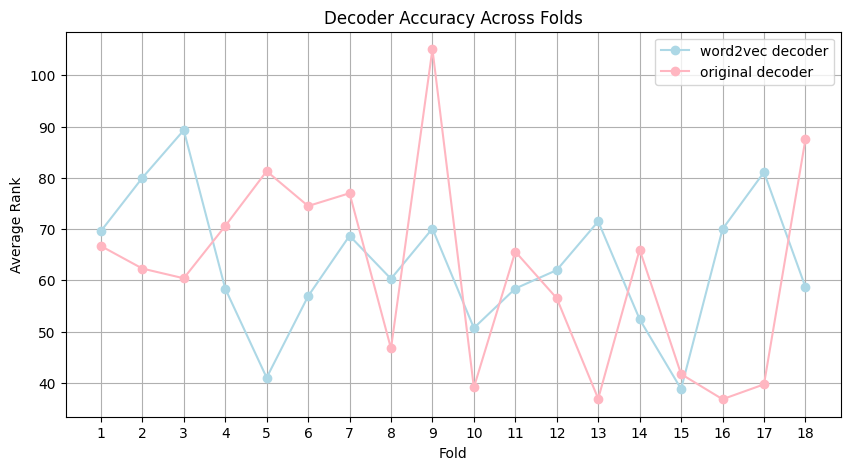

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_folds + 1), avg_ranks_word2vec, marker='o', label='word2vec decoder', color='lightblue')
plt.plot(range(1, num_folds + 1), avg_ranks_og, marker='o', label='original decoder', color='lightpink')
plt.xlabel("Fold")
plt.ylabel("Average Rank")
plt.title("Decoder Accuracy Across Folds")
plt.xticks(range(1, num_folds + 1))
plt.legend()
plt.grid()
plt.show()

In [9]:
import pandas as pd

df_concept_ranks = pd.DataFrame(concept_ranks, columns=["Concept", "Rank"])

# Best decoded concepts (lowest rank)
print("Top 10 best-decoded concepts:")
print(df_concept_ranks.sort_values("Rank").head(10).to_string(index=False))

# Worst decoded concepts (highest rank)
print("\nBottom 10 worst-decoded concepts:")
print(df_concept_ranks.sort_values("Rank", ascending=False).head(10).to_string(index=False))


Top 10 best-decoded concepts:
Concept  Rank
     do     1
   time     1
   food     1
  great     2
  laugh     4
 stupid     5
   lady     6
   left     6
   hair     7
  money     7

Bottom 10 worst-decoded concepts:
        Concept  Rank
argumentatively   180
      cockroach   178
       applause   175
        deceive   171
       electron   168
       dissolve   164
          movie   159
       elegance   158
         usable   158
            sew   157


In [10]:
import pandas as pd

df = pd.DataFrame(concept_ranks, columns=["Concept", "Rank"])
concept_avg_ranks = df.groupby("Concept").mean()

# Count how many concepts had average rank < 90
good_concepts = concept_avg_ranks[concept_avg_ranks["Rank"] < 90]
print(f"Number of concepts with average rank < 90: {len(good_concepts)}")

# Also show overall mean rank
overall_avg_rank = concept_avg_ranks["Rank"].mean()
print(f"Overall average concept rank: {overall_avg_rank:.2f}")


Number of concepts with average rank < 90: 134
Overall average concept rank: 61.91


In [11]:
# ToDo: Read Pereira et al., 2018 and describe the similarities and differences between analyzes 1, 2, and 3 in that paper.
 

## Analysis 2

In [12]:
# Load Data
with open("analyses 2 and 3 data/EXP2.pkl", "rb") as f:
    exp2 = pickle.load(f)

glove_vectors_second_analysis = np.loadtxt("analyses 2 and 3 data/vectors_384sentences.GV42B300.average.txt")
fmri_second_analysis = exp2['Fmridata']

In [44]:
data = pd.read_csv("analyses 2 and 3 data/neuralData_for_EXP1.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)
M = learn_decoder(data, vectors)

In [45]:
predicted_vectors_second_analysis = fmri_second_analysis @ M
ranks = []
for i in range(len(predicted_vectors_second_analysis)):
    rank = average_rank(predicted_vectors_second_analysis[i], i, glove_vectors_second_analysis)
    ranks.append(rank)

rank_accuracies = [1 - (r - 1) / (len(glove_vectors_second_analysis) - 1) for r in ranks]
mean_rank_accuracy = np.mean(rank_accuracies)

print(f"Mean Rank Accuracy for analysis 2: {mean_rank_accuracy:.4f}")

Mean Rank Accuracy for analysis 2: 0.5929
